# Phase-Only Multi-Oscillator Model with VIP, AVP, and Light:
# How to analyze synchrony from phase 
# How to collect a PRC
# How to entrain

## Fresh start code: February 28, 2023

In [1]:
# imports first! just the usual
import numpy as np
from scipy import integrate
import scipy.stats
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

## Background and Math

### Basic network with VIP

We are going to implement a model in which each neuron is simply tracking the angle of its clock hand. Without any signaling, each neuron has the following ODE

$$\frac{d\phi}{dt} = \omega$$

where $\phi$ is an angle in radians and $\omega$ is the intrinsic speed. A 24-h oscillator would have $\omega = \frac{2\pi}{24} = \frac{\pi}{12}$.

But, in the SCN, neurons are connected and receive signals that affect the speed of each clock. The most important of these is VIP. We have an idea of how VIP affects the phase of each neuron because Sungwon An (in the lab of Erik Herzog) collected a PRC to VIP (An et al, 2011). 


The PRC to VIP is show in Figure 1D:

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

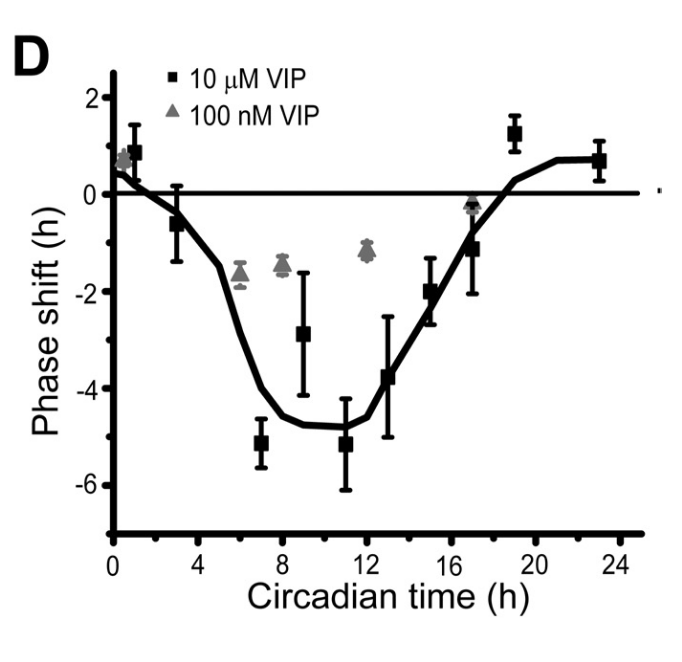
</div>

We see that the PRC is mostly delays and that the largest delay is at the end of the (CT12). I am going to make the assumption that this PRC (to an addition of VIP to the system) gives us the basic shape of the VRC. I am going to use a cosine curve for the sake of simplicity.

This makes the model more complicated. For the ith oscillator, we have

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where $VIPin_i$ is the amount of VIP received by the ith oscillator. It is determined by the phases of the neurons that send VIP to neuron $i$ and by the amount of VIP being sent.

To determine $VIPin_i$ (a scalar), we need info about which neurons send how much VIP to neuron $i$. We will to represent the VIP coupling network with an adjacency matrix $A$. If there are $N$ neurons in the network, then the coupling network is $N \times N$. The entry $A_{i,j}$ gives us the fraction of VIP coming from neuron $j$ to neuron $i$ (so the columns indicate which neuron a signal is coming **from** and the rows indicate which neuron a signal is going **to**). We have a vector $\vec{VIPout}$ that contains the 1 in the jth location if VIP is being sent by neuron $j$ at that time. Then, we use matrix-vector multiplication to compute $\vec{VIPin}$.

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

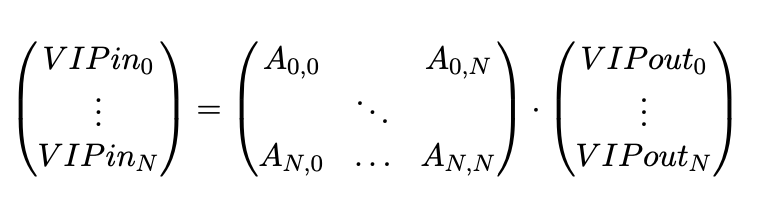
</div>

So, I write the entire model as

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where

$$VIPin(\vec{\phi(t)}) = A \cdot VIPout(\vec{\phi(t)})$$

where $VIPout_j(\phi_j(t)) = 1$ if $\phi_j$ is in a given range and $0$ otherwise. Since VIP is day-active, it makes sense to have each cell output it during the day (that is CT0 to CT12, which is $\phi=0 to $\phi=\pi$.

### Adding AVP

Arginine vasopressin (AVP) is a second, important neuropeptide in the SCN. It has been shown that removing the ability for neurons to receive AVP affects the response to jetlag, but not the PRC to light or the synchrony (Yamaguchi et al, 2013). AVP is sent from neurons in the shell to other neurons in the shell and possibly neurons in the core of the SCN (there is conflicting evidence regarding AVP being sent to VIP neurons).

We are going to add AVP to our model today. To do, we need an AVP network and a VRC to AVP. Fortunately, we have a PRC to AVP collected by Kayla Rohr in the lab of Jenn Evans (Rohr et al, 2021).

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

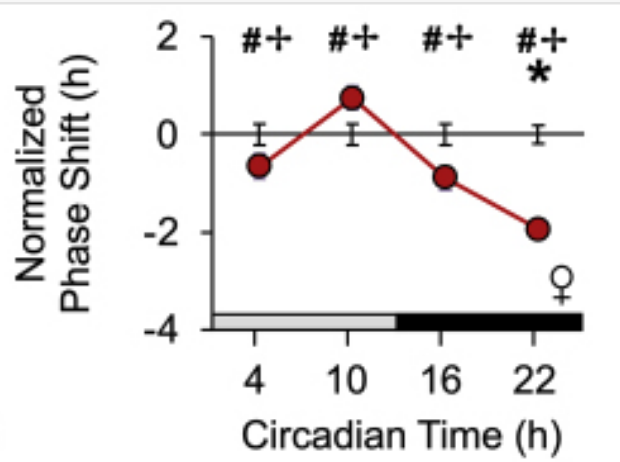
</div>



*References*

An, S., Irwin, R. P., Allen, C. N., Tsai, C. A. & Herzog, E. D. Vasoactive intestinal polypeptide requires parallel changes in adenylate cyclase and phospholipase C to entrain circadian rhythms to a predictable phase. Journal of Neurophysiology 105, 2289–2296 (2011).

Rohr, K. E., Inda, T. & Evans, J. A. Vasopressin resets the central circadian clock in a manner influenced by sex and vasoactive intestinal polypeptide signaling. Neuroendocrinology (2021) doi:10.1159/000521286.

Yamaguchi, Y. et al. Mice Genetically Deficient in Vasopression V1a and V1b Receptors Are Resistant to Jet Lag. Science 342, (2013).



## How to assess synchrony

At any given moment, how synchronized are the oscillations? This question is relatively simple to answer if we know the phase of each oscillator and by "synchronized", we mean "similar in phase". Chronobiologists frequently plot their phase data with each point on the unit circle. A vector is drawn from the center of the circle at the average phase angle. Its length reflects how similar the phases are. Typically, this is called a Rayleigh plot (though this is not the term Steven Strogatz uses in the figure I show below)

<div style="max-width:200px;margin-left: auto; margin-right: auto;">

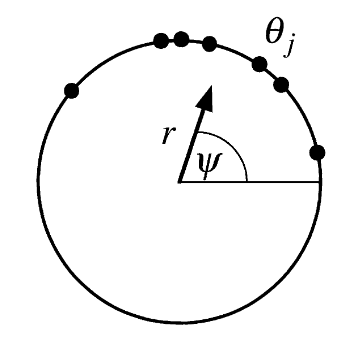
</div>

The length of this vector in the plot is $r$ and is referred to either as the Kuramoto order parameter, the order parameter, or the sync index. It is calculated according to:


$$ r e^{i\psi} = \frac{1}{N}\sum_{j=1}^{N}e^{i\theta_j} $$

where $\psi$ is the average phase.

*Reference*

Strogatz, S. H. From Kuramoto to Crawford: Exploring the onset of synchronization in populations of coupled oscillators. Physica D: Nonlinear Phenomena 143, 1–20 (2000).


[]

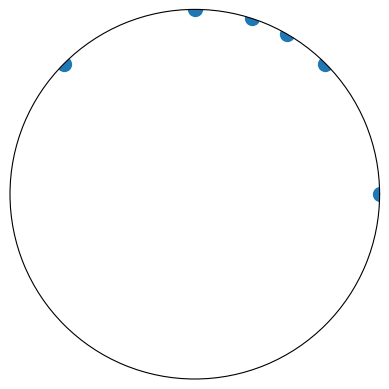

In [2]:
phases = np.array([0, np.pi/3, np.pi/4, np.pi/2, 1.5*np.pi/2, 0.8*np.pi/2])
plt.polar( phases, np.ones(phases.shape), 'o', markersize=10);
ax = plt.gca()
ax.set_rticks([])
ax.set_rmax(1)
ax.set_xticks([])

In [3]:
# Given an array of phases (in radians),
# return the mean phase, using circular statistics
# The formula is given on Wikipedia's page for the circular mean
# (https://en.wikipedia.org/wiki/Circular_mean)
# The chief references for circular statistics is a book: 
# Jammalamadaka, S. Rao and SenGupta, A. (2001). Topics in Circular Statistics, 
#      Section 1.3, World Scientific Press, Singapore. ISBN 981-02-3778-2
def circ_mean(phases):
    C = np.mean( np.cos(phases ) )
    S = np.mean( np.sin(phases) )
    angle = np.arctan2( S, C )
    return angle

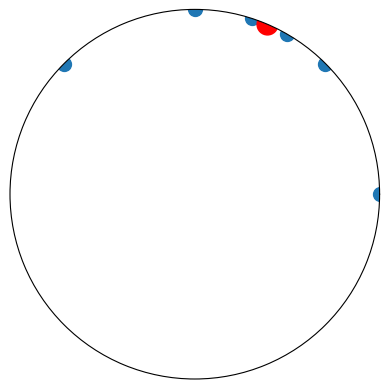

In [4]:
phases = np.array([0, np.pi/3, np.pi/4, np.pi/2, 1.5*np.pi/2, 0.8*np.pi/2])
plt.polar( phases, np.ones(phases.shape), 'o', markersize=10);
mphi = circ_mean(phases)
plt.polar( [mphi], [1], 'o', color='red', markersize=15)
ax = plt.gca()
ax.set_rticks([])
ax.set_rmax(1)
ax.set_xticks([]);

In [5]:
def orderParameter( phases ):
    z = np.mean( np.exp(1j*phases))
    r = np.abs(z)
    return r

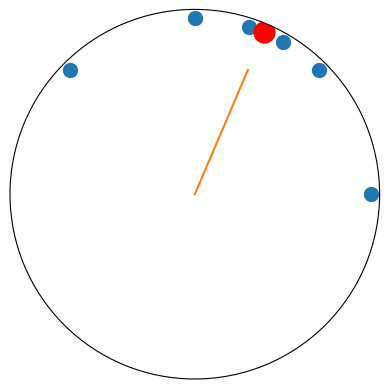

In [6]:
phases = np.array([0, np.pi/3, np.pi/4, np.pi/2, 1.5*np.pi/2, 0.8*np.pi/2])
plt.polar( phases, np.ones(phases.shape), 'o', markersize=10);
mphi = circ_mean(phases)
R = orderParameter(phases)
plt.polar( [mphi], [1], 'o', color='red', markersize=15)
ax = plt.gca()
ax.set_rticks([])
ax.set_rmax(1)
ax.set_xticks([]);
plt.polar( [mphi, mphi], [0, R]);

### VRC code

Let's start by generating a function that will produce a VIP PRC like that observed experimentally.

In [7]:
# This is function SRT grabbed from her jetlag paper.
# It is more adjustable than we need at the moment, but we will
# use it regardless.
# VRC that adjusts the area under a cosine curve.
# for VIP, shift_rad should be 0 rad
# for AVP, the ideal shift_rad is pi (half out of phase)
def VRC_adjustable3(phi,Darea,Aarea,shift_rad):
    phase = np.mod(phi+shift_rad,2*np.pi)
    if phase >= np.pi/2 and phase < np.pi/2+np.pi:
        # in the delay section
        a = Darea/0.5
    else:
        # in the advance section
        a = Aarea/0.5;
    VRC = a * np.cos( phase )
    return VRC

Plot the VRC that we will use by default. We will not have it be too delay-heavy. This is a simplifying assumption, and this is something that should be adjusted (explored this semester)

Text(0.5, 1.0, 'VRC')

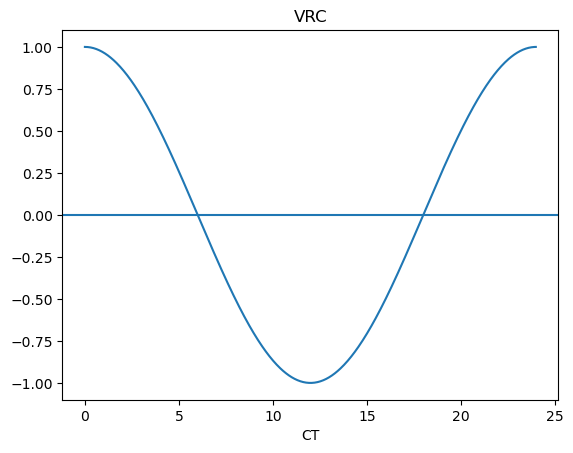

In [8]:
# Plot it!
VIP_Darea = 0.5
VIP_Aarea = 1-VIP_Darea
phis = np.arange( 0, 2*np.pi, 0.01 )
CTs = (12/np.pi)*phis
VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phis] ).reshape( (phis.size,) )
plt.plot( CTs, VIP_VRC )
plt.axhline()
plt.xlabel( "CT");
plt.title( "VRC")

### Adjacency matrix for VIP coupling network

The VIP coupling network is rather complicated, so let's write a function to create it. 

For a network to be connected, every cell must receive an input. In this case, a very few cells are supplying the output. Let's create the sparsest network possible - each neuron receives VIP from exactly one VIP cell. 

In our version 1 of the network, we will assume VIP cells don't receive VIP. There is biological evidence for this, but we will soon find this isn't the best assumption (hence, V2 of this function below).

In [9]:
# 10% of cells are VIP, and they are in the core. no reason not to put them next to each other because there is no local network among them.
# each cell receives VIP from exactly one VIP cell
# The key difference between this model and v1 is that VIP cells
# signal each other.
# In this model, the averaging is built into the matrix. In the mechanistic model, it isn't
# indexing: to, from
def VIP_conn_v2( N, VIP_strength ):
    if VIP_strength < 1e-8:
        return np.zeros( (N,N) )
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # to, from
        # every nonVIP cell gets input from one VIP cell
        A[VIPcount+i::VIPcount,i] = VIP_strength
        # Each VIP cell gets input from its neighbor in a 
        # circle
        A[(i+1)%VIPcount,i] = VIP_strength
    denom = np.count_nonzero( A, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            A[i,:] = A[i,:] / denom[i]
    return A



### Code to plot a network

Check out the fancy curves.

In [10]:
def plot_network(conn, N, half, rows, cols, title=None):
    VIP_count = int(0.1*N)
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    plt.figure()
    for i in range(N):
        r1,c1 = np.unravel_index( i, (rows,cols))
        for j in range(N):
            if conn[i,j] > 0:
                r2,c2 = np.unravel_index( j, (rows,cols))
#                 plt.plot( (c1,c2), (r1,r2), 'k-' )
                if c1 > c2:
                    # arrow goes from c2 to c1, so it goes from right to left
                    cdiff = c1-c2-0.05
                elif c1 == c2:
                    cdiff = c1-c2
                else:
                    cdiff = c1-c2+0.05
                if r1 > r2:
                    # arrow goes from r2 to r1, so it goes up
                    rdiff = r1-r2-0.05
                elif r1 == r2:
                    rdiff = r1-r2
                else:
                    rdiff = r1-r2+0.05
#                 plt.arrow( c2, r2, cdiff, rdiff, color='k', alpha=0.5, head_width=0.1 )

                x1 = c2
                y1 = r2
                x2 = c2+cdiff
                y2 = r2+rdiff
                style = "Simple, tail_width=0.5, head_width=4, head_length=8"
                kw = dict(arrowstyle=style, color="k", alpha=0.5)
                arrow = patches.FancyArrowPatch((x1, y1), (x2, y2),
                             connectionstyle="arc3,rad=.25", **kw)
                plt.gca().add_patch(arrow)                    
        if i < half:
            plt.plot( c1, r1, 'ro')
            # VIP cells are 10% of the cells and they are clustered in the core
            if i < VIP_count:
                plt.plot( c1, r1, 'yv' )
        else:
            plt.plot( c1, r1, 'bo')
            # AVP cells are 20% of the cells and they are spread out throughout the shell
            if np.mod(i-half, AVP_skip) == 0:
                plt.plot( c1, r1, 'm^' )
        if title is not None:
            plt.title(title)

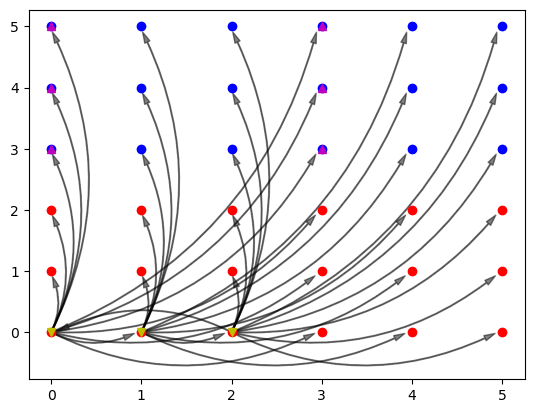

In [11]:
N = 36
VIP_strength = 1
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

VIPconn = VIP_conn_v2( N, VIP_strength )
plot_network( VIPconn, N, half, rows, cols )
plt.show()


### Adjacency matrix for AVP coupling network

The AVP coupling network is rather complicated, and we are going to need to make and vary assumptions about it. Let's start with the simplest set.

We know that about 20% of neurons in the SCN are AVPergic and that they are located in the shell (Ono et al, 2021), we will will spread those AVP cells throughout the second half of our network.

Further, the AVP network may be more local than the VIP network (though the evidence is NOT clear to SRT for this one). We will construct it so that AVP is sent to cells that are nearby in our 2D grid. This is another area of adjustment for the model.

*Reference*

Ono, D., Honma, K. I. & Honma, S. Roles of Neuropeptides, VIP and AVP, in the Mammalian Central Circadian Clock. Frontiers in Neuroscience 15, 1–8 (2021).

In [12]:
# 20% of cells are AVP, and they are in the shell. make them every 3rd cell.
# Construct an AVP network with only local coupling a nbrhood_size of 1
# means that each AVP cell sends a signal to its neighbors 1 way up/down/left/right/diagonal
# nbrhood size of 2 means that more than half of the cells receive AVP
def AVP_conn_v1( N, AVP_strength, nbrhood_size = 2 ):
    rows = int(np.sqrt(N))
    cols = int(N/rows)
    half = N//2
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    AVPconn = np.zeros( (N,N) )
    #for j in range(half,half+AVP_count): # AVP cells at beginning of shell
    for j in range(half,N, AVP_skip): # AVP cells spread throughout shell
        # from nodes.
        r,c = np.unravel_index( j, (rows,cols) )
        neighbors = []
        for nridx in range(nbrhood_size+1):
            for ncidx in range(nbrhood_size+1):
                if nridx == 0 and ncidx == 0:
                    continue # no self-signaling
                neighbors.extend([(r-nridx,c-ncidx),(r+nridx,c+ncidx)])
        for nbr in neighbors:
            if nbr[0] >= 0 and nbr[0] < rows and nbr[1] >= 0 and nbr[1] < cols:
                i = np.ravel_multi_index( nbr, (rows,cols) )
                AVPconn[i,j] = AVP_strength
    denom = np.count_nonzero( AVPconn, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            AVPconn[i,:] = AVPconn[i,:] / denom[i]
    return AVPconn


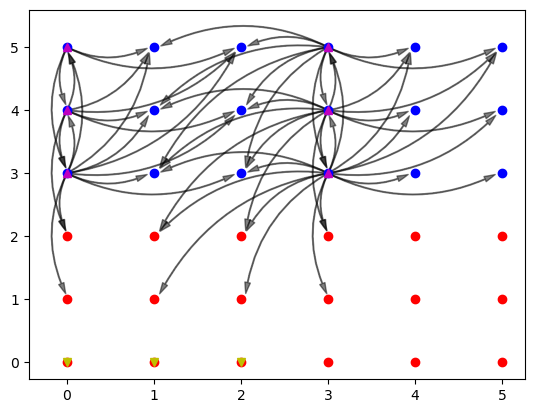

In [13]:
N = 36
AVP_strength = 0.3
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = AVP_conn_v1( N, AVP_strength )
plot_network( AVPconn, N, half, rows, cols )
plt.show()

### Make the model (updated to include VIP, AVP and light)

First we have a class that will hold all the parameters

- an intrinsic speed for each oscillator
- Phases during which VIP is output
- Phases during which AVP is output 
- balance of D and A areas under VIP VRC
- balance of D and A areas under AVP VRC and its phase 
- light strength


Then, we write the model code and a function that will plot the output of the model

In [14]:
def DD(t):
    return 0

# Return the value of light for a pulse at the given time.
# after 1 h, the strength is saturated and the strength drops to
# 20%
# This function is a scale for the Parameter object's light strength
def generic_pulse( t, pulse_start, pulse_stop, strength ):
    if t < pulse_start or t > pulse_stop:
        return 0
    elif t-pulse_start > 1:
        return 0.2*strength
    else:
        return strength
    
# LD12:12 with square signal, but saturation.
def LD12_12( t, strength ):
    if np.mod( t, 24 ) < 1:
        return strength
    elif np.mod( t, 24 ) < 12:
        return 0.2*strength
    return 0

# Changes
#   We specify the start and stop phases of VIP and AVP signaling
#   We allow for VIP to be released by VIP-neurons when they receive light
class Parameters_VipAVPLight_v2:
    def __init__( self, N, VIPconn, AVPconn, intrinsic_periods = None, 
                 VIP_start = 0, VIP_duration= np.pi/2, 
                 AVP_VRC_shift=np.pi, AVP_start=np.pi, AVP_duration=np.pi/2, 
                 lightInducedVIP_strength = 0, light_fn = DD ):
        half = N // 2
        if intrinsic_periods is None:
            np.random.seed( 0 )
            intrinsic_periods = np.random.randn( N ) * 0.5
            intrinsic_periods[:half] += 25
            intrinsic_periods[half:] += 24.4
        # Assume that VIP is sent during day (pretty confident about this assumption)
        VIP_active_start = VIP_start
        VIP_active_stop = VIP_active_start+VIP_duration; 
        VIP_Darea = 0.5;
        # Assume that AVP is sent during day, just like VIP. Is that a good assumption?
        # AVP levels in cerebrospinal fluid higher in morning than at night (Reppert et al, Science 1981), so it might be fine.
        # This is something we can adjust
        AVP_active_start = AVP_start;
        AVP_active_stop = AVP_active_start+AVP_duration; 
        AVP_Darea = 0.5;
        self.N = N
        self.VIPconn = VIPconn
        self.AVPconn = AVPconn
        self.VIPergic = np.any( VIPconn, axis=0 )
        self.light_fn = light_fn
        self.intrinsic_speeds = np.reshape( (2*np.pi)/intrinsic_periods, (N,) )
        self.params = np.array( [VIP_Darea, VIP_active_start, VIP_active_stop, 
                                 AVP_Darea, AVP_VRC_shift, AVP_active_start, 
                                 AVP_active_stop, lightInducedVIP_strength] )

In [15]:
# Model function to be used by solve_ivp
# t is a scalar (time)
# phi is the vector of phases for each cell
# pobj is the Parameters_VipAVPLight_v2 object 
# New: VIP cells may send VIP when receive light, even if it 
#      isn't during the usual VIP-sending phase
def model_vip_avp_light_v2(t,phi,pobj):
    N = pobj.N
    phi = np.mod(phi,2*np.pi);
    VIP_Darea = pobj.params[0] # fraction of total area
    VIP_Aarea = 1-VIP_Darea # fraction of total area
    VIP_active_start = pobj.params[1]
    VIP_active_stop = pobj.params[2]
    AVP_Darea = pobj.params[3] # fraction of total area
    AVP_Aarea = 1-VIP_Darea # fraction of total area
    AVP_VRC_shift = pobj.params[4]
    AVP_active_start = pobj.params[5]
    AVP_active_stop = pobj.params[6]
    lightInducedVIP_strength = pobj.params[7]

    speed = pobj.intrinsic_speeds

    # Determine which cells see light and how much
    light_input = pobj.light_fn(t)*pobj.VIPergic

    # Evaluate the VIP VRC at the phase for each of the oscillators
    VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phi] ).reshape( (N,) )
    VIP_output = np.zeros( (N,) )
    VIP_output[np.logical_and( VIP_active_start <= phi, phi <= VIP_active_stop )] = 1
    # NEW!!!
    # assuming all cells receive light, make it so cells release at least as much VIP
    # as light is inducing.
    # We rely on 2 assumptions - all VIP cells receive light and the network will make it so 
    # we can't tell VIP is released from nonVIP cells
    VIP_output = np.fmax( VIP_output, lightInducedVIP_strength*light_input)
    AVP_VRC = np.array( [VRC_adjustable3(p,AVP_Darea,AVP_Aarea,AVP_VRC_shift) for p in phi] ).reshape( (N,) )
    AVP_output = np.zeros( (N,) )
    AVP_output[np.logical_and( AVP_active_start <= phi, phi <= AVP_active_stop )] = 1

    # This code makes it look like we sum the input, but the connectivity matrix is set up so that
    # each entry has already been divided by the number of entries that send to a particular cell
    VIP_input = pobj.VIPconn @ VIP_output
    AVP_input = pobj.AVPconn @ AVP_output

    dydt = speed + VIP_VRC*(VIP_input+light_input) + AVP_VRC*AVP_input
    return dydt

In [16]:
def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        Note that this is meant for the estimates of MP - i.e. it isn't meant for
        phases. We are using this so that we can use the same methods of analysis
        That we would use for data. Also, it works better for computing the over all period
        (i.e. analyze the mean MP for all neurons)."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)


In [17]:
# Plot the output of the model
#  pobj is the Parameters_VipAVP object
#  sol is the output of solve_ivp
def plot_VIP_AVP_light( pobj, sol, include_order = False ):
    if include_order:
        num_rows = 4
    else:
        num_rows = 3
    VIPsenders = pobj.VIPconn.sum(axis=0)
    phi = np.mod( sol.y, 2*np.pi )
    MP = np.sin( sol.y )
    per, sd_per = get_period( ts, MP.mean(axis=0) )
    ax = plt.subplot( num_rows, 1, 1 )
    plt.plot( ts, phi.T )
    plt.plot( ts, phi[pobj.VIPergic,:].T, color='orange' )
    yl = plt.ylim()
    for i in range(ts.size-1):
        l = pobj.light_fn(ts[i])
        if l > 0:
            r = patches.Rectangle( (ts[i],yl[0]), ts[i+1]-ts[i], yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )
    plt.ylabel( 'phi mod 2pi')

    ax = plt.subplot( num_rows, 1, 2 )
    plt.plot( ts, MP.T, 'k', alpha=0.5 )
    plt.plot( ts, MP[pobj.VIPergic,:].T, color='orange' )
    yl = plt.ylim()
    for i in range(ts.size-1):
        l = pobj.light_fn(ts[i])
        if l > 0:
            r = patches.Rectangle( (ts[i],yl[0]), ts[i+1]-ts[i], yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )
    plt.ylabel( 'Per mRNA')
    plt.title( f"Period of mean(MP) is {per:.02f} +/- {sd_per:0.2f}")
    
    
    ax = plt.subplot( num_rows, 1, 3 )
    dphidt = np.diff( sol.y.T, axis=0 )/(ts[1]-ts[0])
    plt.plot( ts[:-1], dphidt, 'k', alpha=0.2 );
    plt.plot( ts[:-1], np.diff( sol.y[pobj.VIPergic,:].T, axis=0 )/(ts[1]-ts[0]), color='orange', alpha=0.5 );    
    yl = plt.ylim()
    for i in range(ts.size-1):
        l = pobj.light_fn(ts[i])
        if l > 0:
            r = patches.Rectangle( (ts[i],yl[0]), ts[i+1]-ts[i], yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )
    plt.xlabel( "time (h)")
    plt.ylabel( 'dphi/dt')
    
    if include_order:
        ax = plt.subplot( num_rows, 1, 4 )
        Rs = np.apply_along_axis( orderParameter, axis=0, arr=sol.y )
        plt.plot( ts, Rs );
        yl = plt.ylim()
        for i in range(ts.size-1):
            l = pobj.light_fn(ts[i])
            if l > 0:
                r = patches.Rectangle( (ts[i],yl[0]), ts[i+1]-ts[i], yl[1]-yl[0], alpha=0.5, facecolor='y' )
                ax.add_patch( r )
        plt.xlabel( "time (h)")
        plt.ylabel( 'R')

    plt.tight_layout()

### Simulate the model in DD

took 1.0712218284606934 seconds to simulate


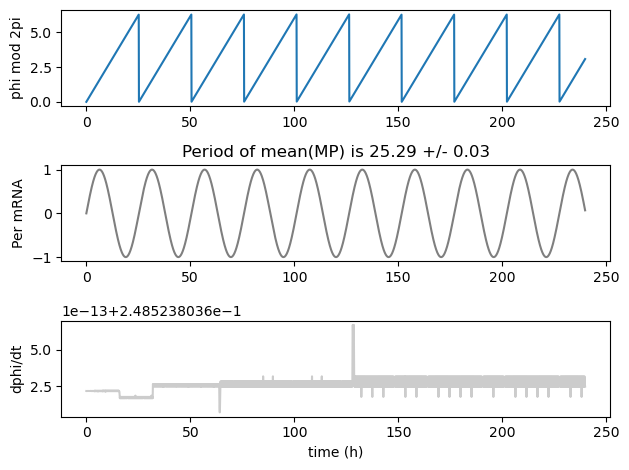

In [18]:
# Simulate 1 neuron in DD without a network
# NEW! I added a min_step requirement
N = 1
VIP_strength = 0
VIP_duration = 0
VIPconn = np.zeros( (N,N) )
AVPconn = np.zeros( (N,N) )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, 
                                 VIP_start = 0, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0,
                          method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol )


took 6.81553316116333 seconds to simulate


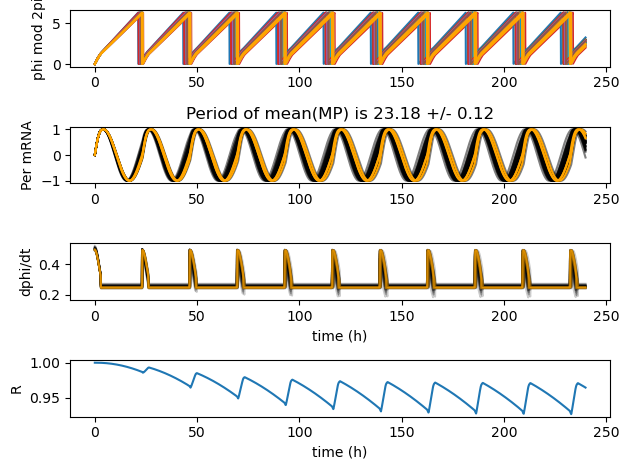

In [19]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP), 
# but make AVP strength zero.
N = 36
VIP_strength = 0.25
AVP_strength = 0.0
VIP_start = 0
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVP_start = np.pi
AVP_duration = np.pi/2
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, 
                                  VIP_start = VIP_start, VIP_duration=VIP_duration,
                                 AVP_start = AVP_start, AVP_duration=AVP_duration,
                                 light_fn = light_fn )
model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, 
                          method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol, include_order = True )

took 7.7328550815582275 seconds to simulate


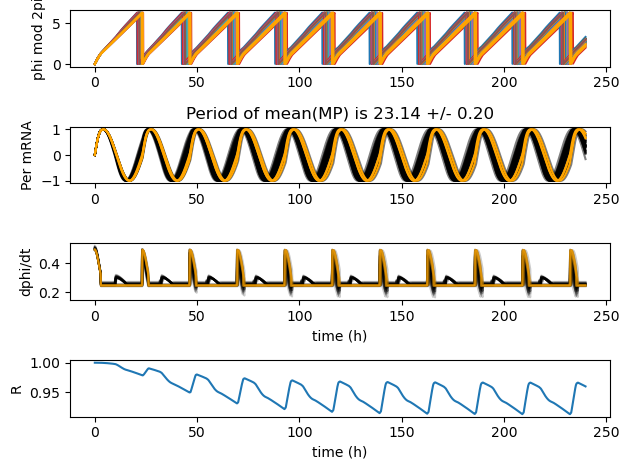

In [20]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP).
# Same as above, but AVP_strength = 0.05 instead of 0
N = 36
VIP_strength = 0.25
AVP_strength = 0.05
VIP_start = 0
VIP_duration = 2*np.pi/5

VIPconn = VIP_conn_v2( N, VIP_strength )
AVP_start = np.pi
AVP_duration = np.pi/2
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, 
                                  VIP_start = VIP_start, VIP_duration=VIP_duration,
                                 AVP_start = AVP_start, AVP_duration=AVP_duration,
                                 light_fn = light_fn )
model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, 
                          method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol, include_order = True )

took 4.154654026031494 seconds to simulate


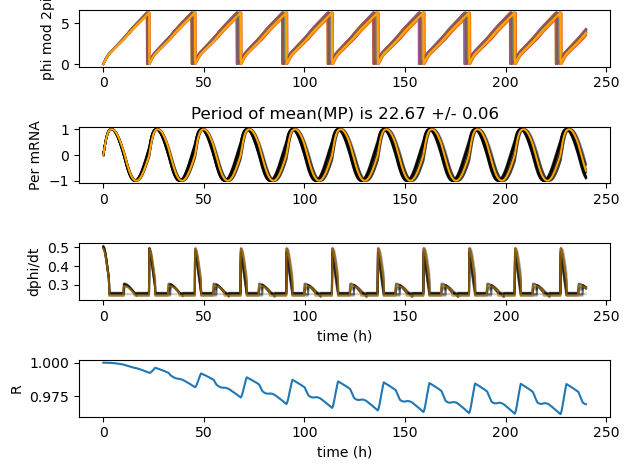

In [21]:
# Let's get this faster with smaller N.
# DD from perfect sync
N = 16
VIP_strength = 0.25
AVP_strength = 0.05
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_start =0, 
                                 VIP_duration=VIP_duration, light_fn=light_fn )
model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, 
                          method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol, include_order = True )

took 4.4374473094940186 seconds to simulate


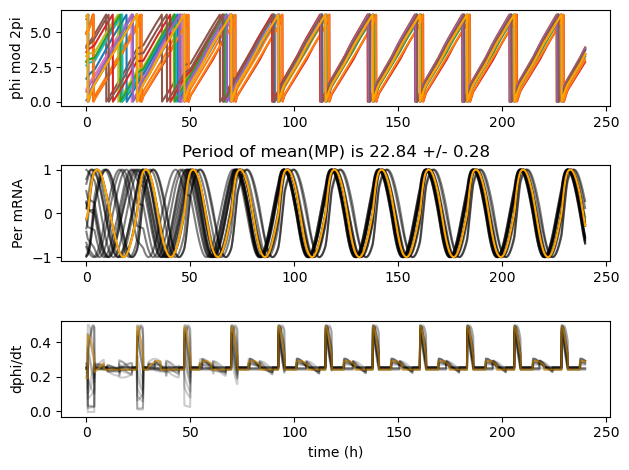

In [22]:
# Another smaller N run.
# DD from async
N = 16
VIP_strength = 0.25
AVP_strength = 0.05
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.random.random( (N,) )*2*np.pi
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_start =0, 
                                 VIP_duration=VIP_duration, light_fn=light_fn )
model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, 
                          method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol )

### Simulate with light (just making sure it behaves the way we expect)

took 7.51677680015564 seconds to simulate


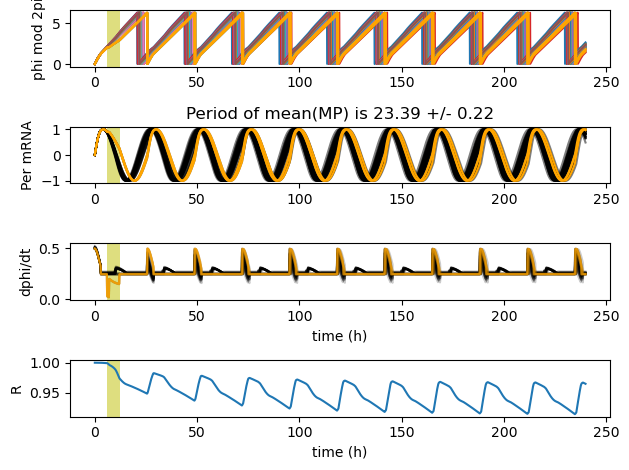

In [23]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP, V1 for light)
# Simulate a single pulse of light

N = 36
VIP_strength = 0.25
AVP_strength = 0.05
VIP_start = 0
VIP_duration = 2*np.pi/5

VIPconn = VIP_conn_v2( N, VIP_strength )
AVP_start = np.pi
AVP_duration = np.pi/2
AVPconn = AVP_conn_v1( N, AVP_strength )

pulse_start = 6
pulse_stop = 12
light_strength = 0.5
light_fn = lambda t: generic_pulse( t, pulse_start, pulse_stop, light_strength )


end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, 
                                  VIP_start = VIP_start, VIP_duration=VIP_duration,
                                 AVP_start = AVP_start, AVP_duration=AVP_duration,
                                 light_fn = light_fn )

model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", 
                          t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol, include_order = True )

took 8.105719804763794 seconds to simulate


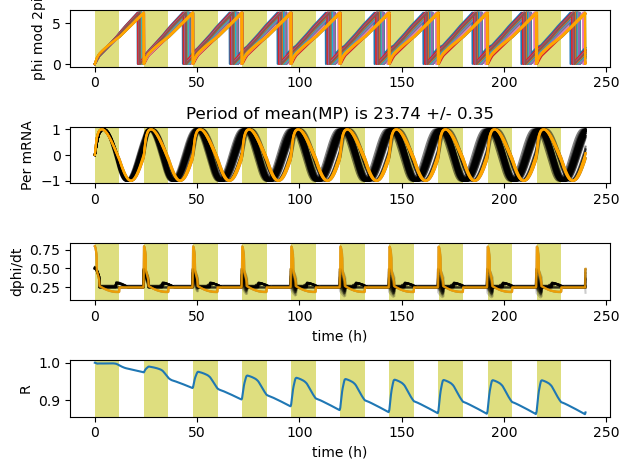

In [24]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP, V1 for light)
# Simulate entrainment with LD12:12
N = 36
VIP_strength = 0.25
AVP_strength = 0.05
VIP_start = 0
VIP_duration = 2*np.pi/5

VIPconn = VIP_conn_v2( N, VIP_strength )
AVP_start = np.pi
AVP_duration = np.pi/2
AVPconn = AVP_conn_v1( N, AVP_strength )

light_strength = 0.3
light_fn = lambda t: LD12_12( t, light_strength )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, 
                                  VIP_start = VIP_start, VIP_duration=VIP_duration,
                                 AVP_start = AVP_start, AVP_duration=AVP_duration,
                                 light_fn = light_fn )

model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", 
                          t_eval = ts, max_step=0.01, min_step=0.001 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP_light( pobj, sol, include_order = True )

## Prepping for entrainment and jetlag runs by finding CT0

Simulate the model from arbitrary initial conditions. Let it run for 400 hours, assuming it syncs in that time. Then, determine the period. Find the peak of the mean per mRNA in that last cycle. Then go back 1/4th of a cycle. That is CT0.

In [25]:
def find_CT0( N, model_fn, min_SI=0.8, debug=False ):
    ''' Given a model function, find the overall CT0.
       We need the Sync Index (order parameter) to be at least min_SI for it to "work"
       Returns the y0 associated with CT0.
       For each cell, we compute the per mRNA output with the function sin(phi).
       CT0 is defined as 6 circadian hours before the peak of the mean per mRNA
    '''
    end_time = 400
    dt = 0.1
    ts = np.arange(0,end_time,dt)
    ps0 = np.zeros( (N,) )
    sol = integrate.solve_ivp( fun = model_fn, t_span = (0, end_time), y0=ps0, 
                              method="LSODA", t_eval = ts, max_step=0.01, min_step=0.001 )
    Rs = np.apply_along_axis( orderParameter, axis=0, arr=sol.y )
    MPs = np.sin(sol.y) # is NY x NT, sol.t is (NT,)
    # check the SI at the end of the simulation
    if Rs[-1] < min_SI: 
        return ps0, Rs, False
    mean_MP = MPs.mean( axis = 0 )
    period, sdperiod = get_period( sol.t, mean_MP )
    psteps = int(period/dt)
    CT6_steps = int(6.0/24*period/dt)
    peak_idx = mean_MP[-psteps:].argmax() + mean_MP.size - psteps
    CT0 = sol.y[:,peak_idx-CT6_steps]
    if debug:
        plt.figure()
        plt.subplot( 3, 1, 1 )
        plt.plot( sol.t, MPs.T )
        plt.ylabel( 'MP')
        plt.subplot( 3, 1, 2 )
        plt.plot( sol.t, Rs )
        plt.ylabel( 'R')
        plt.subplot( 3, 1, 3 )
        plt.plot( sol.t, mean_MP )
        plt.plot( sol.t[peak_idx], mean_MP[peak_idx], 'r*' )
        plt.plot( sol.t[peak_idx-CT6_steps], mean_MP[peak_idx-CT6_steps], 'g*' )
        plt.plot( "mean MP")
        plt.title( f"Period = {period:02f} +/- {sdperiod:02f}" )
        plt.tight_layout()
    return CT0, Rs, True    


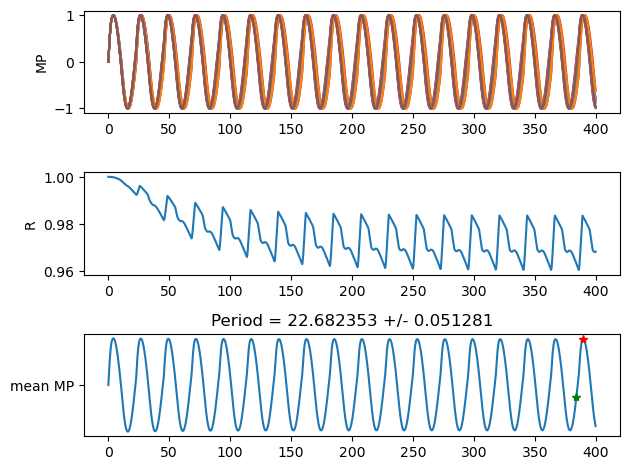

In [26]:
# Test find_CT0
N = 16
VIP_strength = 0.25
AVP_strength = 0.05
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.random.random( (N,) )*2*np.pi
pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_start =0, 
                                 VIP_duration=VIP_duration, light_fn=light_fn )
model_fn = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
CT0 = find_CT0( N, model_fn, min_SI=0.9, debug=True )


## Collect a PRC

Start a reference simulation at CT0. Compute the mean per mRNA (meanMP) over time for that reference simulation. We will compare the peak timing of this reference meanMP to the peak of meanMP for each simulation that has a light pulse.

For each light pulse, we run a simulation starting from that circadian time (i.e. CT6 is 1/4 of the way through the cycle), with the given duration of the light pulse (in hours). We compare the peak time of meanMP in the last cycle of the simulation (simuation is 240h long) to the peak time of the meanMP in the last cycle of the reference simulation. We then make sure the time is in the range -FRP/2 to FRP/2.

In [27]:
# Assumes phase-only model.
def collect_PRC(pobj, light_strength, pulse_duration=1, draw_plots=False, pulse_starts=None):
    if pulse_starts is None:
        pulse_starts = np.linspace( 0, 24, 24 ) # start a pulse once every hour
    PRC = np.zeros(pulse_starts.shape);
    AVPsenders = pobj.AVPconn.sum(axis=0)
    VIPsenders = pobj.VIPergic
    
    N = pobj.N
    modelDD = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
    
    CT0, Rs, sync = find_CT0(N, modelDD)
    if not sync:
        print( "Can't collect a PRC for a model that doesn't sync" )
        return pulse_starts, [], np.inf
    dt = 0.01
    t = np.arange(0,300,dt)
    sol_ref = scipy.integrate.solve_ivp(fun=modelDD, t_span=(0,300), y0=CT0, 
                                        method='LSODA', rtol=1e-3, atol=1e-8, 
                                        t_eval=t, max_step=0.01, min_step=0.001 )
    print( f"reference took {sol_ref.nfev} steps" )
    # sol.y is NY x NT

    # Determine the FRP so that we can space out the
    # Pulses over the entire cycle
    ref_mean_MP = np.sin(sol_ref.y).mean(axis=0)
    FRP, _ = get_period( sol_ref.t, ref_mean_MP )
    if draw_plots:
        print( f"FRP = {FRP:02f}" )
    psteps = int(FRP/dt);
    refPeakIdx = ref_mean_MP[-psteps:].argmax()
    refPeakTime = sol_ref.t[-psteps+refPeakIdx-1];
    pulse_starts = (FRP/24)*pulse_starts

    if draw_plots:
        plt.figure(figsize=(12, pulse_starts.size))

    for pulseIdx in range(pulse_starts.size):
        pulse_start = pulse_starts[pulseIdx]
        print( "pulse_start", pulse_start )
        b = time.time()
        pulse_stop = pulse_start + pulse_duration
        pulse_fn = lambda t: generic_pulse( t, pulse_start, pulse_stop, light_strength )
        pobj.light_fn = pulse_fn
        model = lambda t,ps: model_vip_avp_light_v2( t, ps, pobj )
        sol = scipy.integrate.solve_ivp(fun=model, t_span=(sol_ref.t[0], sol_ref.t[-1]), 
                                           y0=sol_ref.y[:,0], method='LSODA', rtol=1e-3, atol=1e-8, 
                                           t_eval=sol_ref.t, max_step=0.01, min_step=0.001)
        if sol.status < 0:
            print( f"failed to compute pulse at {pulse_start}")
            continue
        # Now, compare the peak time of this simulation to that
        # of the reference trajectory.
        mean_MP = np.mean(np.sin(sol.y), axis=0)
        peakIdx = mean_MP[-psteps:].argmax()
        peakTime = sol.t[-psteps+peakIdx-1]
        # advance should be positive.
        shift = refPeakTime - peakTime;
        # and make sure a 20-h delay shows up as a 4-h advance..
        if np.abs(shift) > FRP/2:
            if shift < 0:
                shift = shift + FRP;
            else:
                shift = shift - FRP;
        # Finally, put it into the array with the result.
        PRC[pulseIdx] = shift;
        e = time.time()
        print( f"time to collect pulse: {e-b} seconds" )
        #print( f"pulse took {sol_ref.nfev} steps" )

        if draw_plots:
            # This part is really for debugging/understanding
            ax =plt.subplot( pulse_starts.size, 3, 3*pulseIdx+1 )
            plt.plot( sol_ref.t, ref_mean_MP, 'k' )
            plt.plot( sol_ref.t, np.sin(sol_ref.y.T), 'k', alpha=0.2 )
#             plt.plot( sol_ref.t, np.sin(sol_ref.y[np.nonzero(VIPsenders)[0],:].T), 'y', alpha=0.5 )
#             plt.plot( sol_ref.t, np.sin(sol_ref.y[np.nonzero(AVPsenders)[0],:].T), 'g', alpha=0.5 )
            plt.plot( t, mean_MP, 'b' )
            plt.plot( t, np.sin(sol.y.T), 'b', alpha=0.2 )
#             plt.plot( t, np.sin(sol.y[np.nonzero(VIPsenders)[0],:].T), 'r', alpha=0.5 )
#             plt.plot( t, np.sin(sol.y[np.nonzero(AVPsenders)[0],:].T), 'm', alpha=0.5 )

#             plt.plot( sol_ref.t, np.mod(sol_ref.y.T, 2*np.pi), 'k', alpha=0.2 )
#             plt.plot( sol_ref.t, np.mod(sol_ref.y[np.nonzero(VIPsenders)[0],:].T, 2*np.pi), 'y', alpha=0.5 )
#             plt.plot( sol_ref.t, np.mod(sol_ref.y[np.nonzero(AVPsenders)[0],:].T, 2*np.pi), 'g', alpha=0.5 )
#             plt.plot( t, np.mod(sol.y.T, 2*np.pi), 'b', alpha=0.2 )
#             plt.plot( t, np.mod(sol.y[np.nonzero(VIPsenders)[0],:].T, 2*np.pi), 'r', alpha=0.5 )
#             plt.plot( t, np.mod(sol.y[np.nonzero(AVPsenders)[0],:].T, 2*np.pi), 'm', alpha=0.5 )
            plt.xlim( [0,120] )
            plt.title(f"shift = {shift:0.3f}")
            yl = plt.ylim()
            r = patches.Rectangle( (pulse_start,yl[0]), pulse_duration, yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )
            
            ax = plt.subplot( pulse_starts.size, 3, 3*pulseIdx+2 )
            plt.plot( sol_ref.t[:-1], np.diff( sol_ref.y.T, axis=0 ), 'k', alpha=0.2 )
            plt.plot( sol_ref.t[:-1], np.diff( sol_ref.y[np.nonzero(VIPsenders)[0],:].T, axis=0 ), 'y', alpha=0.5 )
            plt.plot( sol_ref.t[:-1], np.diff( sol_ref.y[np.nonzero(AVPsenders)[0],:].T, axis=0 ), 'g', alpha=0.5 )
            plt.plot( t[:-1], np.diff( sol.y, axis=1 ).T, 'b', alpha=0.2 )
            plt.plot( t[:-1], np.diff( sol.y[np.nonzero(VIPsenders)[0],:], axis=1 ).T, 'r', alpha=0.5 )
            plt.plot( t[:-1], np.diff( sol.y[np.nonzero(AVPsenders)[0],:], axis=1 ).T, 'm', alpha=0.5 )
            plt.xlim( [0,36] )
            plt.ylabel( 'dtphi/dt' )
            yl = plt.ylim()
            r = patches.Rectangle( (pulse_start,yl[0]), pulse_duration, yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )
            
            ax = plt.subplot( pulse_starts.size, 3, 3*pulseIdx+3 )
            VRCs = np.zeros( sol.y.shape )
            VIP_Darea = pobj.params[1] # fraction of total area
            VIP_Aarea = 1-VIP_Darea # fraction of total area
            for i in range( sol.y.shape[0] ):
                VRCs[i,:] = [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in sol.y[i,:]]
            plt.plot( t, VRCs.T, 'b', alpha=0.2 )
            plt.plot( t, VRCs[np.nonzero(VIPsenders)[0],:].T, 'r', alpha=0.5 )
            plt.axhline( color = 'k' )
            plt.xlim( [0,36] )
            yl = plt.ylim()
            r = patches.Rectangle( (pulse_start,yl[0]), pulse_duration, yl[1]-yl[0], alpha=0.5, facecolor='y' )
            ax.add_patch( r )


        
    if draw_plots:
        plt.tight_layout()
    return pulse_starts, PRC, FRP

reference took 47240 steps
FRP = 22.698333
pulse_start 0.0
time to collect pulse: 5.919506788253784 seconds
pulse_start 4.539666666666667
time to collect pulse: 5.876836061477661 seconds
pulse_start 9.079333333333334
time to collect pulse: 5.812828779220581 seconds
pulse_start 13.619
time to collect pulse: 5.7867090702056885 seconds
pulse_start 18.15866666666667
time to collect pulse: 5.876759052276611 seconds
pulse_start 22.698333333333334
time to collect pulse: 5.819542169570923 seconds


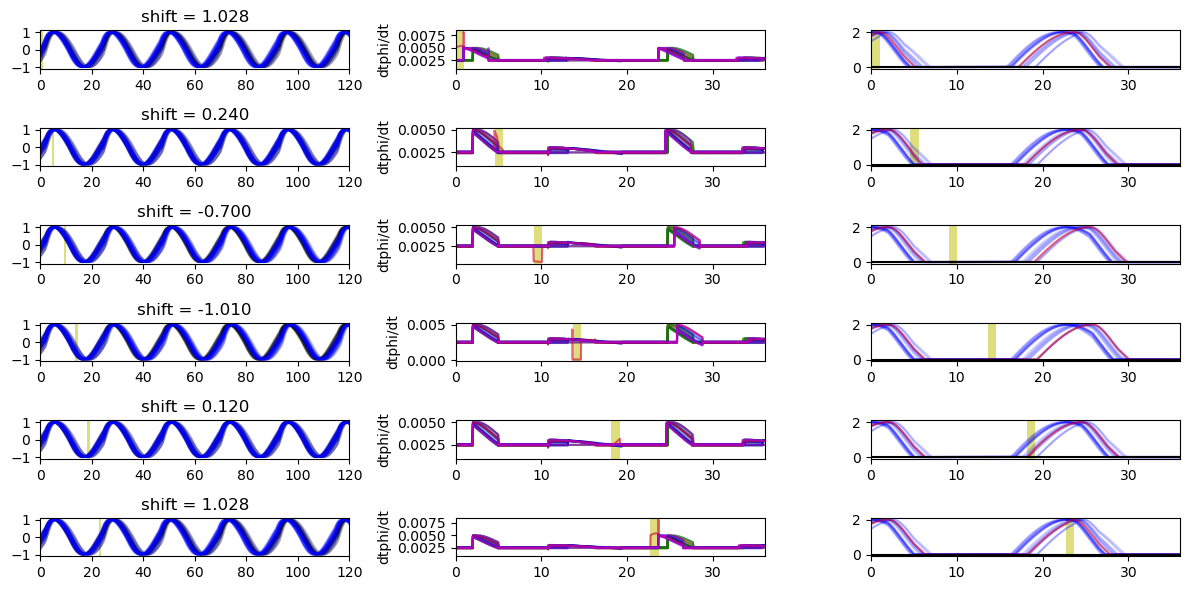

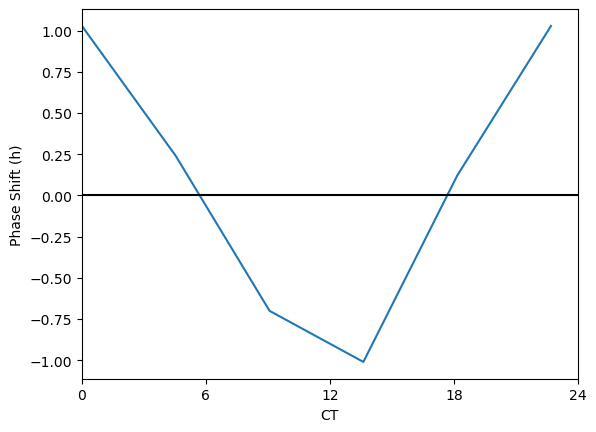

In [28]:
# Test the PRC code
# This test has no light-induced VIP signals
N = 16
VIP_strength = 0.25
AVP_strength = 0.05
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD
light_strength = 0.3
pulse_starts = np.linspace( 0, 24, 6 ) # start a pulse once every 4 hours

pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_start =0, 
                                 VIP_duration=VIP_duration, light_fn=light_fn )

pulse_starts, PRC, period = collect_PRC(pobj, light_strength, pulse_duration=1,
                                        draw_plots=True, 
                                        pulse_starts=pulse_starts)
plt.figure()
plt.plot( pulse_starts, PRC )
plt.axhline(color='k')
plt.xticks( [0,6,12,18,24])
plt.xlim([0, 24])
plt.xlabel( "CT")
plt.ylabel( "Phase Shift (h)");

reference took 47240 steps
FRP = 22.698333
pulse_start 0.0
time to collect pulse: 6.006530046463013 seconds
pulse_start 4.539666666666667
time to collect pulse: 5.934680223464966 seconds
pulse_start 9.079333333333334
time to collect pulse: 5.763822078704834 seconds
pulse_start 13.619
time to collect pulse: 5.757289171218872 seconds
pulse_start 18.15866666666667
time to collect pulse: 5.993955850601196 seconds
pulse_start 22.698333333333334
time to collect pulse: 5.796056747436523 seconds


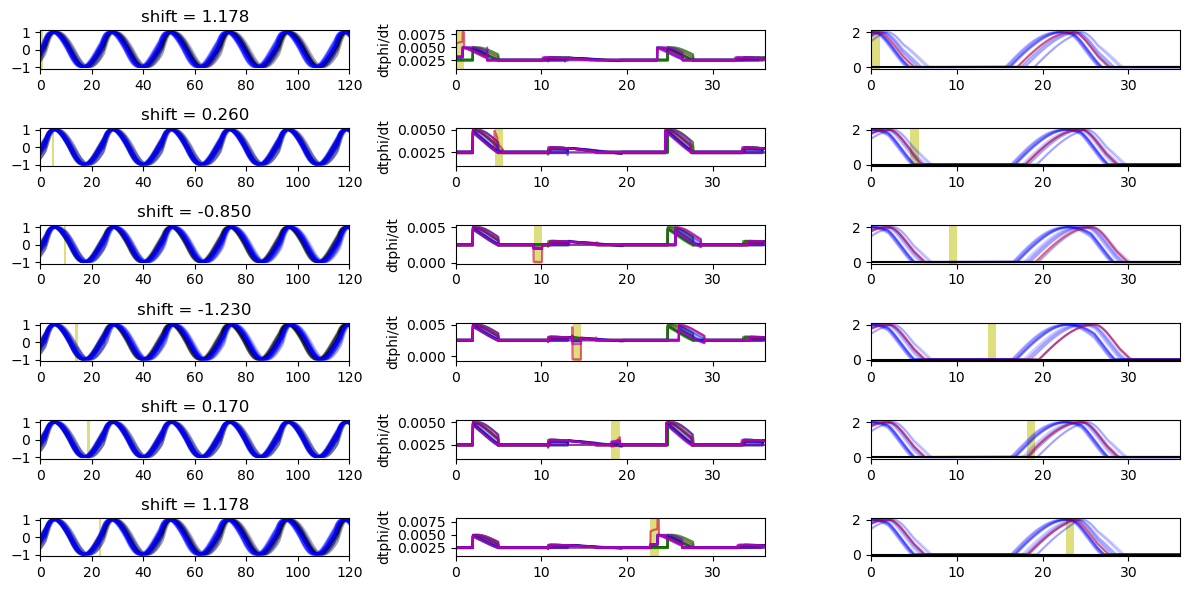

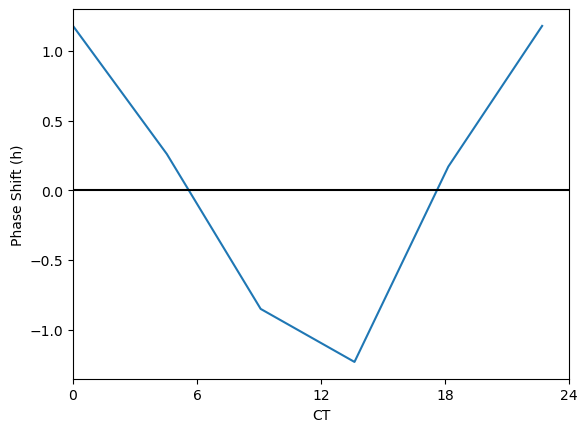

In [29]:
# Test the PRC code
# This test has light-induced VIP signals.
N = 16
VIP_strength = 0.25
AVP_strength = 0.05
VIP_duration = 2*np.pi/5
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )
light_fn = DD
light_strength = 0.3
lightInducedVIP_strength = 1*VIP_strength/light_strength
pulse_starts = np.linspace( 0, 24, 6 ) # start a pulse once every 4 hours

pobj = Parameters_VipAVPLight_v2( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_start =0, 
                                 VIP_duration=VIP_duration, light_fn=light_fn,
                                lightInducedVIP_strength=lightInducedVIP_strength )

pulse_starts, PRC, period = collect_PRC(pobj, light_strength, pulse_duration=1,
                                        draw_plots=True, 
                                        pulse_starts=pulse_starts)
plt.figure()
plt.plot( pulse_starts, PRC )
plt.axhline(color='k')
plt.xticks( [0,6,12,18,24])
plt.xlim([0, 24])
plt.xlabel( "CT")
plt.ylabel( "Phase Shift (h)");